In [1]:
# import modules
import os
import pandas as pd
import numpy as np
from scipy.stats import randint
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from math import sqrt
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
warnings.filterwarnings('ignore')

## Data Precprocessing 

In [2]:
# assign path
path, dirs, files = next(os.walk('../data/csv'))
file_count = len(files)

# create empty list
dataframes_list = []
# append datasets to the list 
for i in range(file_count):
    temp_df = pd.read_csv(path+'/'+files[i])
    temp_df = temp_df.drop(columns='year')
    
    # Assign a unique pollutant number to each dataset
    # The value of 'i+1' ensures that each dataset is assigned a unique number starting from 1
    temp_df.insert(2, 'Pollutant', i+1) # 
    dataframes_list.append(temp_df)

# Concatenate dataframes into one signle dataframe
df = pd.concat(dataframes_list, ignore_index= True)    

In [3]:
# Standardizing Data
scaler = StandardScaler()

# Apply StandardScaler to each column except the third one (index 2)
for col in df.columns:
    if df.columns.get_loc(col) != 2:  # Checks if the column index is not 2
        df[col] = scaler.fit_transform(df[[col]])   

## Data Exploration & Visualization

In [4]:
df.isnull().sum()

x            0
y            0
Pollutant    0
conct        0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29282140 entries, 0 to 29282139
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   x          float64
 1   y          float64
 2   Pollutant  int64  
 3   conct      float64
dtypes: float64(3), int64(1)
memory usage: 893.6 MB


In [6]:
df.describe()

,x,y,Pollutant,conct
count,2.928214e+07,2.928214e+07,2.928214e+07,2.928214e+07
mean,3.704553e-15,-1.224374e-16,3.000000e+00,-1.643136e-16
std,1.000000e+00,1.000000e+00,1.414214e+00,1.000000e+00
min,-1.878738e+00,-2.028950e+00,1.000000e+00,-1.123693e+00
25%,-8.421617e-01,-8.240802e-01,2.000000e+00,-6.046423e-01
50%,-3.992524e-03,3.078914e-02,3.000000e+00,-1.303285e-01
75%,8.341766e-01,8.391981e-01,4.000000e+00,3.145508e-01
max,2.205481e+00,1.927918e+00,5.000000e+00,5.150201e+02


In [7]:
# Check skewness of each column
print(df.skew())

x            0.034434
y           -0.080669
Pollutant    0.000000
conct        9.786052
dtype: float64


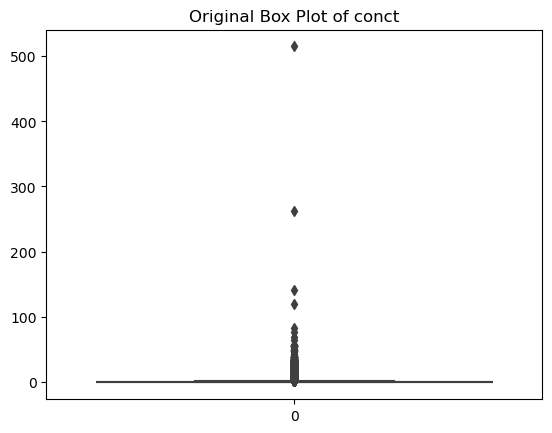

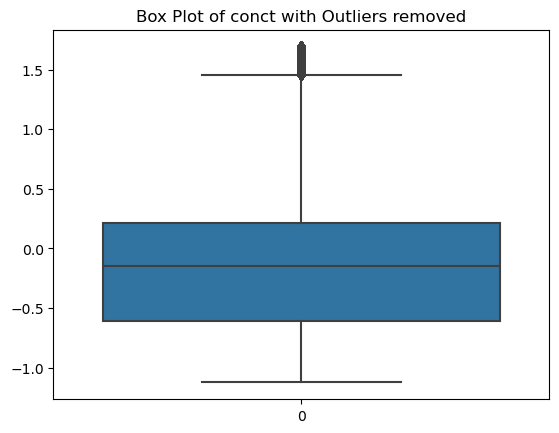

In [8]:
# Function to remove outliers from a specified column using the IQR method
def remove_outliers(df, column):
    # Display the original data distribution in a box plot for visual inspection
    sns.boxplot(df[column])
    plt.title(f'Original Box Plot of {column}')
    plt.show()
    
    # Calculate the IQR which is the difference between 75th and 25th percentiles
    for x in [column]:
        q75,q25 = np.percentile(df.loc[:,x],[75,25])
        intr_qr = q75-q25
        
        # Define the upper and lower bounds for outliers
        max = q75+(1.5*intr_qr)
        min = q25-(1.5*intr_qr)
    
        # Replace outliers with NaN for later removal
        df.loc[df[x] < min,x] = np.nan
        df.loc[df[x] > max,x] = np.nan
        
    # Remove rows with NaN values in the column to clear out the outliers
    df[column].isnull().sum()
    df = df.dropna()
    
    # Display a box plot of the data column after removing outliers
    sns.boxplot(df[column])
    plt.title(f'Box Plot of {column} with Outliers removed')
    plt.show()
    
    # Return the dataframe with outliers removed
    return df

# Remove outliers from the 'conct' column, presenting many outliers 
df = remove_outliers(df, 'conct')

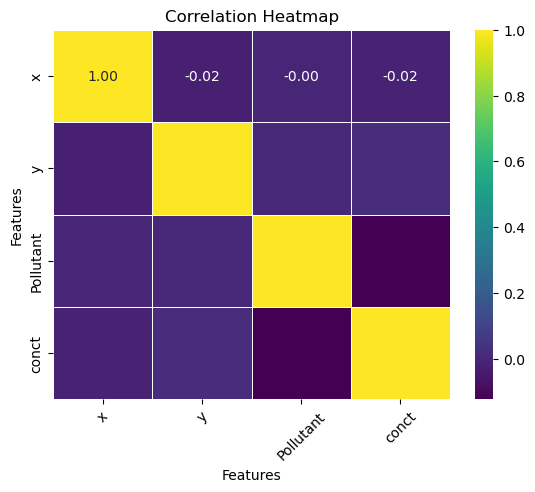

In [9]:
''' Generate and display a heatmap of the correlation matrix for dataframe columns 
to visually inspect the pairwise correlations between features'''
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot = True, cmap = 'viridis', 
            fmt = '0.2f', linewidth = 0.5)
plt.title('Correlation Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')
plt.xticks(rotation = 45)
plt.show()

[Text(0.5, 1.0, 'Concentrations Histogram')]

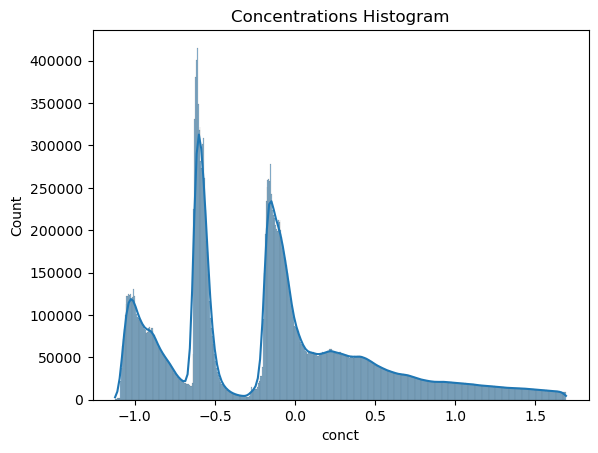

In [10]:
# Plotting Histogram (kde = kernel density)
sns.histplot(df['conct'], kde=True).set(title='Concentrations Histogram')

In [11]:
# Uncomment the following code to generate a 3D scatter plot
'''# Create a 3D scatter plot to visualize the relationships between the 'x', 'y', 
# and 'conct' variables in the dataset
fig = plt.figure(figsize = (20,20))
plt.style.use('classic')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['x'], df['y'],df['conct'], c = 'red')
ax.set_xlabel('x', fontsize = 20)
ax.set_ylabel('y', fontsize = 20)
ax.set_zlabel('conct', fontsize = 20)'''

"# Create a 3D scatter plot to visualize the relationships between the 'x', 'y', \n# and 'conct' variables in the dataset\nfig = plt.figure(figsize = (20,20))\nplt.style.use('classic')\nax = fig.add_subplot(111, projection='3d')\nax.scatter(df['x'], df['y'],df['conct'], c = 'red')\nax.set_xlabel('x', fontsize = 20)\nax.set_ylabel('y', fontsize = 20)\nax.set_zlabel('conct', fontsize = 20)"

## Regression Models

In [12]:
X = df.drop(columns='conct').values  #features
y = df['conct']  # Target variable

In [13]:
# using the train test split function 
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=104, test_size=0.25, shuffle=True) 

In [14]:
# Function to evaluate the performance of regression models
def evaluate(model, X_train, X_test, y_train, y_test):
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

# Evaluation metrics
    print(f'TRAINING RESULTS FOR {model}: \n==============================================================')
    print(f'Mean Absolute Error (MAE) - Training: {mean_absolute_error(y_train, y_train_pred):.4f}')
    print(f'Mean Squared Error (MSE) - Training: {mean_squared_error(y_train, y_train_pred):.4f}')
    print(f'R-squared (R²) Score - Training: {r2_score(y_train, y_train_pred):.4f}')

    print(f'\nTESTING RESULTS FOR {model}: \n==============================================================')
    print(f'Mean Absolute Error (MAE) - Testing: {mean_absolute_error(y_test, y_test_pred):.4f}')
    print(f'Mean Squared Error (MSE) - Testing: {mean_squared_error(y_test, y_test_pred):.4f}')
    print(f'R-squared (R²) Score - Testing: {r2_score(y_test, y_test_pred):.4f}')

# Predicted vs Actual Density Plot
    plt.figure(figsize=(10, 6))
    sns.kdeplot(x=y_test, y=y_test_pred, cmap="Reds", fill=True)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Density Plot of Actual vs Predicted Values')
    plt.show()

# Residuals Hexbin Plot
    residuals = y_test - y_test_pred
    plt.figure(figsize=(10, 6))
    sns.kdeplot(x=y_test_pred, y=residuals, cmap="Purples", fill=True)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Density Residual Plot')
    plt.show()

#### Model 1: Decision Tree

#####   Step 1: Finding the best parameters for the Decision Tree model

In [15]:
# Define the parameter distribution to sample from
param_dist = {
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20)
}
dtree = DecisionTreeRegressor(random_state=42)
random_search = RandomizedSearchCV(dtree, param_distributions=param_dist, 
                                   n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
params_dt= random_search.best_params_
best_score_random = random_search.best_score_

print(f"Best Parameters: {params_dt}")
print(f"Best Score (Random Search): {best_score_random}")

Best Parameters: {'max_depth': 15, 'min_samples_leaf': 19, 'min_samples_split': 13}
Best Score (Random Search): 0.956638762297638


##### Step 2: Build the Decision Tree model using the best paramters

TRAINING RESULTS FOR DecisionTreeRegressor(max_depth=15, min_samples_leaf=19, min_samples_split=13,
                      random_state=42): 
Mean Absolute Error (MAE) - Training: 0.0574
Mean Squared Error (MSE) - Training: 0.0169
R-squared (R²) Score - Training: 0.9575

TESTING RESULTS FOR DecisionTreeRegressor(max_depth=15, min_samples_leaf=19, min_samples_split=13,
                      random_state=42): 
Mean Absolute Error (MAE) - Testing: 0.0578
Mean Squared Error (MSE) - Testing: 0.0172
R-squared (R²) Score - Testing: 0.9568


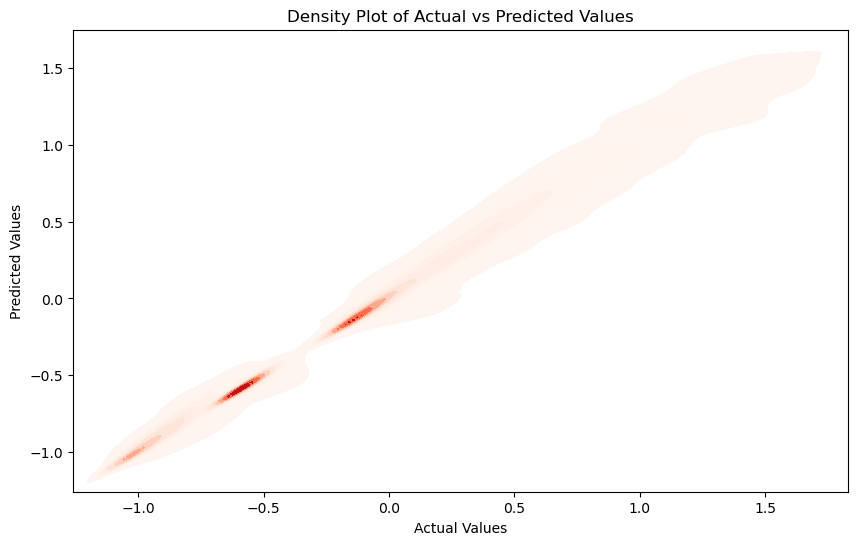

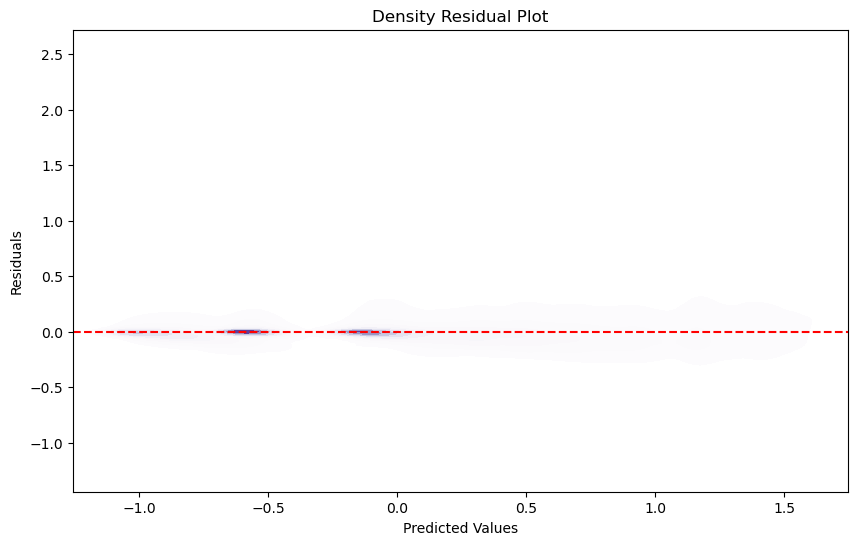

In [16]:
# Train the Decision Tree model on the training dataset using the best parametrs
params_dt = {'max_depth': 15, 'min_samples_leaf':19, 'min_samples_split': 13}
best_dtree = DecisionTreeRegressor(random_state=42, **params_dt)
best_dtree.fit(X_train, y_train)
# Predict the results for unseen data using the trained model and evaluate performance
evaluate(best_dtree, X_train, X_test, y_train, y_test)

#### Model 2: KNN Regressor

##### Step 1: Find optimum number of k

Score for k=1: 0.9786543426769576 

Score for k=2: 0.9866740414052656 

Score for k=3: 0.9879386679860462 

Score for k=4: 0.9879725504840033 

Score for k=5: 0.9875882660700364 

Score for k=6: 0.9873169111591197 

Score for k=7: 0.9869669878753468 

Score for k=8: 0.9865602681965884 

Score for k=9: 0.9861556461909875 



<Axes: >

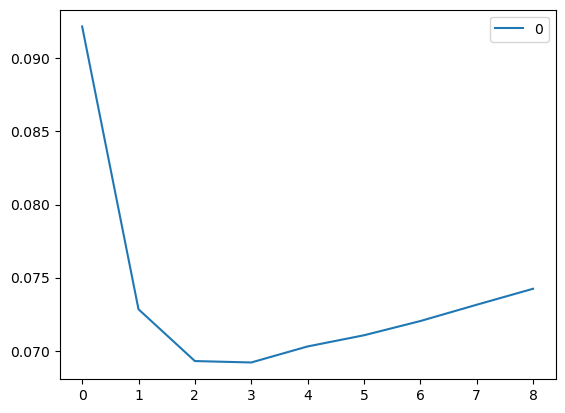

In [17]:
# Find optimum number of k
rmse_val = []
for k in range(1, 10):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    error = sqrt(mean_squared_error(y_test, predictions)) # calculate rmse
    rmse_val.append(error) # store rmse values
    print(f'Score for k={k}: {knn.score(X_test, y_test)} \n')

# Print elbow
curve = pd.DataFrame(rmse_val) # elbow curve 
curve.plot()

##### Step 2: Build KNN model with optimum number of k

TRAINING RESULTS FOR KNeighborsRegressor(n_neighbors=3): 
Mean Absolute Error (MAE) - Training: 0.0130
Mean Squared Error (MSE) - Training: 0.0024
R-squared (R²) Score - Training: 0.9940

TESTING RESULTS FOR KNeighborsRegressor(n_neighbors=3): 
Mean Absolute Error (MAE) - Testing: 0.0192
Mean Squared Error (MSE) - Testing: 0.0048
R-squared (R²) Score - Testing: 0.9879


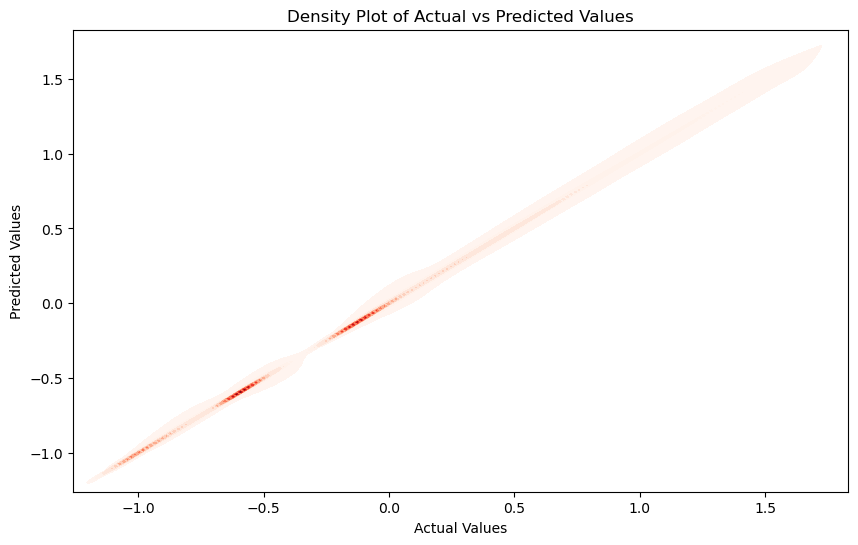

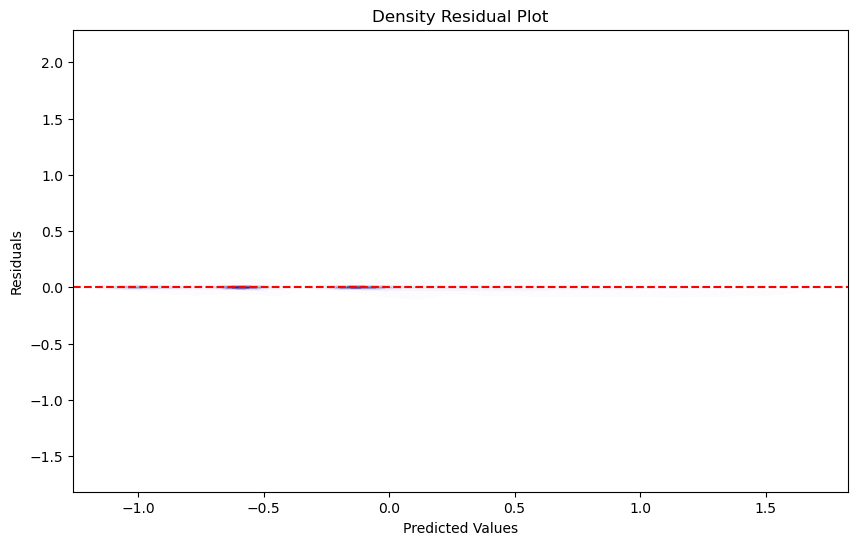

In [18]:
# Train the K-NN model on the training dataset using the optimal number of k
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_train, y_train)
# Predict the results for unseen data using the trained model and evaluate performance
evaluate(knn, X_train, X_test, y_train, y_test)

### !!NOTE: The models below require significant computational power and time to run. Therefore, we will train them using a random sample of 10,000 rows from the original dataset.

In [19]:
# Creating a random sample of 10,000 rows from the orignal dataset
sample_df = df.sample(n=10000, random_state=104)
X_sample = sample_df.drop(columns='conct')
y_sample = sample_df['conct']
# Split the sample dataset into training and testing sets
X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(X_sample, y_sample, random_state=104, test_size=0.2, shuffle=True)

#### Model 3: Support Vector Regressor 

#####   Step 1: Finding the best parameters for the SVR model

In [20]:
# Create an SVR model with an RBF kernel
svr = SVR(kernel='rbf')

# Define a grid of hyperparameters to search over during cross-validation
param_grid = {
    'C': [0.1, 1, 10, 100],              # Regularization parameter
    'gamma': ['scale', 'auto', 0.1, 1]  
}

# Perform Grid Search Cross-Validation to find the best combination of hyperparameters
grid_search = GridSearchCV(estimator=svr,    
                           param_grid=param_grid,   
                           cv=5,        
                           scoring='neg_mean_squared_error',  
                           n_jobs=-1)  

# Fit the grid search to the training data
grid_search.fit(X_sample_train, y_sample_train)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.1, 1]},
             scoring='neg_mean_squared_error')

In [21]:
# Get the best estimator (best SVR model) found by grid search
best_svr = grid_search.best_estimator_
# Use the best SVR model to make predictions on the test data
y_sample_pred = best_svr.predict(X_sample_test)
# Calculate the Mean Squared Error (MSE) 
mse = mean_squared_error(y_sample_test, y_sample_pred)
print("Mean Squared Error:", mse)
# Get the best parameters found during grid search, renamed to params_svr
params_svr = grid_search.best_params_
print("Best Parameters:", params_svr)

Mean Squared Error: 0.024332894926209155
Best Parameters: {'C': 100, 'gamma': 1}


##### Step 2: Build the SVR model using the best paramters

TRAINING RESULTS FOR SVR(C=100, gamma=1): 
Mean Absolute Error (MAE) - Training: 0.0902
Mean Squared Error (MSE) - Training: 0.0243
R-squared (R²) Score - Training: 0.9396

TESTING RESULTS FOR SVR(C=100, gamma=1): 
Mean Absolute Error (MAE) - Testing: 0.0931
Mean Squared Error (MSE) - Testing: 0.0243
R-squared (R²) Score - Testing: 0.9397


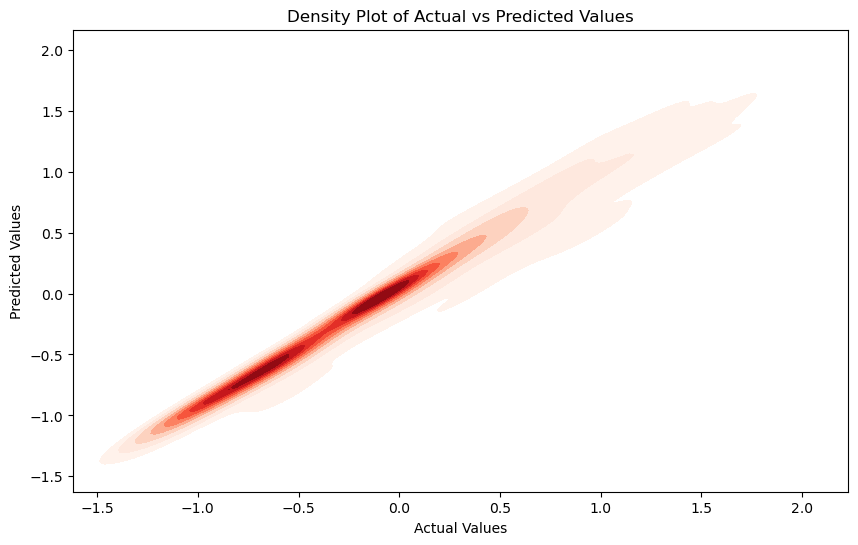

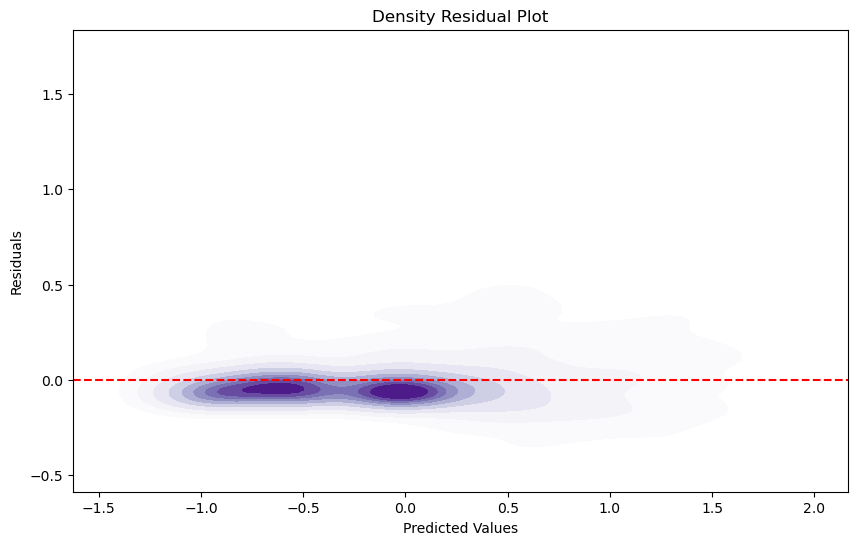

In [22]:
# Train the SVR model on the training dataset using the best parametrs
params_svr = {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
svr = SVR(**params_svr)
svr.fit(X_sample_train, y_sample_train)
# Predict the results for unseen data using the trained model and evaluate performance
evaluate(svr, X_sample_train, X_sample_test, y_sample_train, y_sample_test)

#### Model 4: Stacking Reggressor using Decion Tree, KNN and SVR

TRAINING RESULTS FOR StackingRegressor(cv=KFold(n_splits=5, random_state=RandomState(MT19937) at 0x1463C8140,
   shuffle=False),
                  estimators=[('dt',
                               DecisionTreeRegressor(max_depth=15,
                                                     min_samples_leaf=19,
                                                     min_samples_split=13,
                                                     random_state=42)),
                              ('knn', KNeighborsRegressor(n_neighbors=3)),
                              ('svr', SVR(C=100, gamma=1))],
                  final_estimator=Ridge()): 
Mean Absolute Error (MAE) - Training: 0.0686
Mean Squared Error (MSE) - Training: 0.0177
R-squared (R²) Score - Training: 0.9559

TESTING RESULTS FOR StackingRegressor(cv=KFold(n_splits=5, random_state=RandomState(MT19937) at 0x1463C8140,
   shuffle=False),
                  estimators=[('dt',
                               DecisionTreeRegressor(max_depth=15,
   

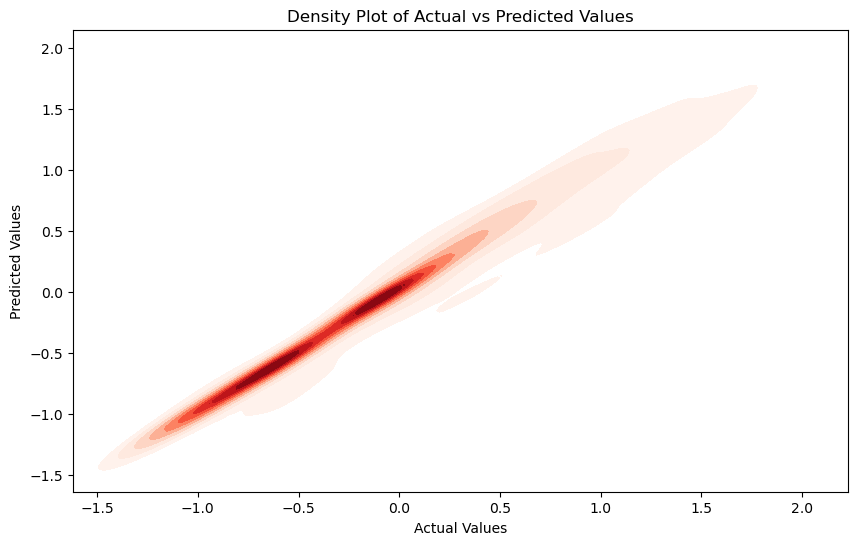

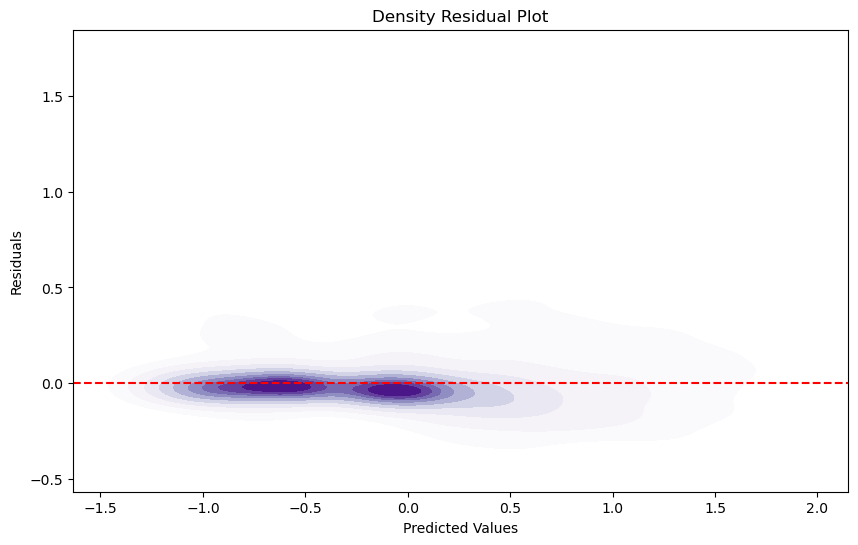

In [23]:
# Parameters identified in the previous models
params_knn = {'n_neighbors': 3}
params_svr = {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
params_dt = {'max_depth': 15, 'min_samples_leaf':19, 'min_samples_split': 13}

estimators = [
    ('dt', DecisionTreeRegressor(random_state=42, **params_dt)), 
    ('knn', KNeighborsRegressor(**params_knn)),  
    ('svr', SVR(**params_svr)),  
]

stacking_regressor = StackingRegressor(
                         estimators=estimators,
                         final_estimator=Ridge(),
                         cv=KFold(n_splits=5, shuffle=False)
                     )

# Train the stacking regressor model on the training dataset
stacking_regressor.fit(X_sample_train, y_sample_train)
# Predict the results for unseen data using the trained model and evaluate performance
evaluate(stacking_regressor, X_sample_train, X_sample_test, y_sample_train, y_sample_test)